# ML Forecasting Analysis 

#### Matthew Fernadnez
##### 8/21/25


The first model in this notebook is an early warnining model. We should be able to accurately predict when the next cleaninig of a container needs to occur with high confidence.

The second model in this notebook is a time-to-event forecasting model where we want to have the ability to predict out n number of weeks a container needs to be swapped.


Models:
1. Classifier Model to predict if a container needs to be **cleaned** or **not** by the next week. 
2. Regression Model to predict when the container will need to be swapped **n** number of weeks out. 




In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV 

import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Shared/bin-cleaning-classifier")


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0143f5dd00>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/927145935820204', creation_time=1757487594510, experiment_id='927145935820204', last_update_time=1757487704411, lifecycle_stage='active', name='/Shared/bin-cleaning-classifier', tags={'mlflow.experiment.sourceName': '/Shared/bin-cleaning-classifier',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'matthew89fernandez@gmail.com',
 'mlflow.ownerId': '72453478617777'}>

In [0]:
THRESHOLD = 0.8

In [0]:
catalog = "workspace"          
schema  = "ml"           
version  = 2  # from the logged param in DanielsHealth_Forecasting_Analysis


ml_table = f"{catalog}.{schema}.bin_cleaning_ml"

ml_sdf = spark.read.format("delta").option("versionAsOf", version).table(ml_table)
ml_df = ml_sdf.toPandas()  # if you need pandas for sklearn



In [0]:
ml_df.head()

,date,fill_level,reuses,container,should_clean_next_week,clean_in_Kw,clean_this_week,next_clean_idx,weeks_until_clean,weekofyear,sin_woy,cos_woy,lag_1,delta_1,lag_2,delta_2,lag_3,delta_3,lag_4,delta_4,lag_5,delta_5,lag_6,delta_6,lag_7,delta_7,lag_8,delta_8,roll_mean_3,roll_std_3,roll_growth_3,roll_mean_6,roll_std_6,roll_growth_6,roll_mean_12,roll_std_12,roll_growth_12,near_thresh,features_ok
0,2018-12-07 07:05:52.821779,0.83,0.0,CT22_C.1.1,1,1,0,13.0,1.0,49,-3.546049e-01,0.935016,0.76,0.07,0.69,0.14,0.62,0.21,0.56,0.27,0.49,0.34,0.42,0.41,0.36,0.47,0.29,0.54,0.760000,0.070000,0.070000,0.658333,0.126715,0.068333,0.460833,0.236699,0.065000,1,True
1,2018-12-16 07:05:52.821779,0.07,1.0,CT22_C.1.1,0,0,1,25.0,12.0,50,-2.393157e-01,0.970942,0.83,-0.76,0.76,-0.69,0.69,-0.62,0.62,-0.55,0.56,-0.49,0.49,-0.42,0.42,-0.35,0.36,-0.29,0.553333,0.420040,-0.206667,0.588333,0.271545,-0.070000,0.457500,0.242304,-0.003333,0,True
2,2018-12-22 07:05:52.821779,0.13,1.0,CT22_C.1.1,0,0,0,25.0,11.0,51,-1.205367e-01,0.992709,0.07,0.06,0.83,-0.70,0.76,-0.63,0.69,-0.56,0.62,-0.49,0.56,-0.43,0.49,-0.36,0.42,-0.29,0.343333,0.422532,-0.210000,0.516667,0.330797,-0.071667,0.454167,0.246851,-0.003333,0,True
3,2018-12-28 07:05:52.821779,0.20,1.0,CT22_C.1.1,0,0,0,25.0,10.0,52,6.432491e-16,1.000000,0.13,0.07,0.07,0.13,0.83,-0.63,0.76,-0.56,0.69,-0.49,0.62,-0.42,0.56,-0.36,0.49,-0.29,0.133333,0.065064,-0.210000,0.446667,0.348521,-0.070000,0.451667,0.249466,-0.002500,0,True
4,2019-01-07 07:05:52.821779,0.27,1.0,CT22_C.1.1,0,0,0,25.0,9.0,2,2.393157e-01,0.970942,0.20,0.07,0.13,0.14,0.07,0.20,0.83,-0.56,0.76,-0.49,0.69,-0.42,0.62,-0.35,0.56,-0.29,0.200000,0.070000,0.066667,0.376667,0.331642,-0.070000,0.450000,0.250708,-0.001667,0,True


Collect predictors needed to predict if container needs servicing next week or not(Binary Classification). Train Test split 80/20. 

In [0]:
feature_cols = [c for c in ml_df.columns
                if c.startswith(('lag_','delta_','roll_','sin_','cos_','near_thresh'))]

# time split for 80% in training and 20% in test sets
cut_idx = int(ml_df['date'].rank(pct=True).quantile(0.8))
cut_date = ml_df['date'].sort_values().iloc[int(0.8*len(ml_df))]

train = ml_df[ml_df['date'] <= cut_date]
test  = ml_df[ml_df['date'] >  cut_date]

X_tr, y_tr = train[feature_cols], train['clean_in_Kw']
X_te, y_te = test[feature_cols],  test['clean_in_Kw']
print("Train/Test rows:", X_tr.shape[0], X_te.shape[0])


Train/Test rows: 12364 3080


Build baseline model using RandomForestClassifier model.

In [0]:
clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    class_weight='balanced_subsample',  # handles imbalance
    random_state=42,
    n_jobs=-1
)
clf.fit(X_tr, y_tr)

proba = clf.predict_proba(X_te)[:,1]
auc = roc_auc_score(y_te, proba)
ap  = average_precision_score(y_te, proba)
print(f"AUC={auc:.3f} | PR-AUC={ap:.3f}")


AUC=0.999 | PR-AUC=0.995


In [0]:
thr = 0.35  # move this to favor recall vs precision
pred = (proba >= thr).astype(int)
print(classification_report(y_te, pred, digits=3))


              precision    recall  f1-score   support

           0      0.997     0.987     0.992      2187
           1      0.969     0.993     0.981       893

    accuracy                          0.989      3080
   macro avg      0.983     0.990     0.987      3080
weighted avg      0.989     0.989     0.989      3080



## Find the Best Params with Grid Search CV on Random Forest Classifier Model

In [0]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
 
rfgrid_clf = RandomForestClassifier(
    random_state=42,
)

grid_search = GridSearchCV(estimator=rfgrid_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   4.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END max_de

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             verbose=2)

Best parameters for RandomForestClassifier model.

In [0]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
RandomForestClassifier(n_estimators=150, random_state=42)


Log the Best model with MLFlow to ensure that versioning and reproducibility is quick and easy. 

In [0]:
best_rf_clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1)

best_rf_clf.fit(X_tr, y_tr)

proba = best_rf_clf.predict_proba(X_te)[:,1]
auc = roc_auc_score(y_te, proba)
ap  = average_precision_score(y_te, proba)
print(f"AUC={auc:.3f} | PR-AUC={ap:.3f}")

thr = 0.35  # move this to favor recall vs precision
pred = (proba >= thr).astype(int)
print(classification_report(y_te, pred, digits=3))

# Save the model to MLFlow
import mlflow, mlflow.sklearn
mlflow.set_experiment("/Shared/bin-cleaning-classifier")
with mlflow.start_run(run_name="BinClean_1.3_Best"):
    mlflow.log_params(best_params)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("ap", ap)
    mlflow.sklearn.log_model(best_rf_clf, "model", input_example=X_te.head(1))
    # also log a sample of the schedule as an artifact CSV
    ml_df.head(100).to_csv("/tmp/schedule_preview.csv", index=False)
    mlflow.log_artifact("/tmp/schedule_preview.csv", artifact_path="artifacts")

AUC=0.999 | PR-AUC=0.995
              precision    recall  f1-score   support

           0      0.996     0.991     0.994      2187
           1      0.978     0.991     0.984       893

    accuracy                          0.991      3080
   macro avg      0.987     0.991     0.989      3080
weighted avg      0.991     0.991     0.991      3080



/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values 

## Build second model to forecast what date a container will need to be replaced

In [0]:
panel_feat = ml_df.copy()
ml_df

,date,fill_level,reuses,container,should_clean_next_week,clean_in_Kw,clean_this_week,next_clean_idx,weeks_until_clean,weekofyear,sin_woy,cos_woy,lag_1,delta_1,lag_2,delta_2,lag_3,delta_3,lag_4,delta_4,lag_5,delta_5,lag_6,delta_6,lag_7,delta_7,lag_8,delta_8,roll_mean_3,roll_std_3,roll_growth_3,roll_mean_6,roll_std_6,roll_growth_6,roll_mean_12,roll_std_12,roll_growth_12,near_thresh,features_ok
0,2018-12-07 07:05:52.821779,0.83,0.0,CT22_C.1.1,1,1,0,13.0,1.0,49,-3.546049e-01,0.935016,0.76,0.07,0.69,0.14,0.62,0.21,0.56,0.27,0.49,0.34,0.42,0.41,0.36,0.47,0.29,0.54,0.760000,0.070000,0.070000,0.658333,0.126715,0.068333,0.460833,0.236699,0.065000,1,True
1,2018-12-16 07:05:52.821779,0.07,1.0,CT22_C.1.1,0,0,1,25.0,12.0,50,-2.393157e-01,0.970942,0.83,-0.76,0.76,-0.69,0.69,-0.62,0.62,-0.55,0.56,-0.49,0.49,-0.42,0.42,-0.35,0.36,-0.29,0.553333,0.420040,-0.206667,0.588333,0.271545,-0.070000,0.457500,0.242304,-0.003333,0,True
2,2018-12-22 07:05:52.821779,0.13,1.0,CT22_C.1.1,0,0,0,25.0,11.0,51,-1.205367e-01,0.992709,0.07,0.06,0.83,-0.70,0.76,-0.63,0.69,-0.56,0.62,-0.49,0.56,-0.43,0.49,-0.36,0.42,-0.29,0.343333,0.422532,-0.210000,0.516667,0.330797,-0.071667,0.454167,0.246851,-0.003333,0,True
3,2018-12-28 07:05:52.821779,0.20,1.0,CT22_C.1.1,0,0,0,25.0,10.0,52,6.432491e-16,1.000000,0.13,0.07,0.07,0.13,0.83,-0.63,0.76,-0.56,0.69,-0.49,0.62,-0.42,0.56,-0.36,0.49,-0.29,0.133333,0.065064,-0.210000,0.446667,0.348521,-0.070000,0.451667,0.249466,-0.002500,0,True
4,2019-01-07 07:05:52.821779,0.27,1.0,CT22_C.1.1,0,0,0,25.0,9.0,2,2.393157e-01,0.970942,0.20,0.07,0.13,0.14,0.07,0.20,0.83,-0.56,0.76,-0.49,0.69,-0.42,0.62,-0.35,0.56,-0.29,0.200000,0.070000,0.066667,0.376667,0.331642,-0.070000,0.450000,0.250708,-0.001667,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15439,2025-07-27 07:05:52.821779,0.36,18.0,P64_C.1.3,0,0,0,NaN,NaN,30,-4.647232e-01,-0.885456,0.27,0.09,0.18,0.18,0.08,0.28,0.83,-0.47,0.73,-0.37,0.64,-0.28,0.55,-0.19,0.46,-0.10,0.270000,0.090000,0.093333,0.408333,0.304198,-0.046667,0.410833,0.235312,0.022500,0,True
15440,2025-07-31 07:05:52.821779,0.45,18.0,P64_C.1.3,0,0,0,NaN,NaN,31,-5.680647e-01,-0.822984,0.36,0.09,0.27,0.18,0.18,0.27,0.08,0.37,0.83,-0.38,0.73,-0.28,0.64,-0.19,0.55,-0.10,0.360000,0.090000,0.090000,0.361667,0.263774,-0.046667,0.433333,0.223864,0.022500,0,True
15441,2025-08-11 07:05:52.821779,0.55,18.0,P64_C.1.3,0,0,0,NaN,NaN,33,-7.485107e-01,-0.663123,0.45,0.10,0.36,0.19,0.27,0.28,0.18,0.37,0.08,0.47,0.83,-0.28,0.73,-0.18,0.64,-0.09,0.453333,0.095044,0.093333,0.315000,0.173753,-0.046667,0.455833,0.220597,0.022500,0,True
15442,2025-08-14 07:05:52.821779,0.65,18.0,P64_C.1.3,0,0,0,NaN,NaN,33,-7.485107e-01,-0.663123,0.55,0.10,0.45,0.20,0.36,0.29,0.27,0.38,0.18,0.47,0.08,0.57,0.83,-0.18,0.73,-0.08,0.550000,0.100000,0.096667,0.410000,0.175385,0.095000,0.479167,0.225447,0.023333,0,True


In [0]:
panel_feat = panel_feat[feature_cols+['date', 'weeks_until_clean', 'features_ok', 'container', 'fill_level']].dropna()

In [0]:
feature_cols = [c for c in panel_feat.columns if c.startswith(('lag_','delta_','roll_','sin_','cos_'))]
data = panel_feat[panel_feat['features_ok']].copy()

# global time cut (80% oldest for train)
cut_date = data['date'].sort_values().iloc[int(0.8*len(data))]
train = data[data['date'] <= cut_date]
test  = data[data['date']  > cut_date]

X_tr, y_tr = train[feature_cols], train['weeks_until_clean']
X_te, y_te = test[feature_cols],  test['weeks_until_clean']
print("Train/Test sizes:", X_tr.shape, X_te.shape)


Train/Test sizes: (12232, 27) (3007, 27)


## How do quantilies for Gradient Boosting Regressor perform on predicting the weeks until next clean on each Container

In [0]:
N_ESTIMATORS=150
MAX_DEPTH=6
LEARNING_RATE=0.05


def gbr_quantile(q):
    return GradientBoostingRegressor(
        loss="quantile", alpha=q,
        n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE, subsample=0.8,
        random_state=42
    )

gbr_p30 = gbr_quantile(0.30).fit(X_tr, y_tr)
gbr_p50 = gbr_quantile(0.50).fit(X_tr, y_tr)  # median
gbr_p70 = gbr_quantile(0.70).fit(X_tr, y_tr)

p30 = gbr_p30.predict(X_te)
p50 = gbr_p50.predict(X_te)
p70 = gbr_p70.predict(X_te)

# basic evaluation on the median (MAE)
mae = mean_absolute_error(y_te, p30)
print(f"P30 model MAE (weeks): {mae:.2f}")

mae_q50 = mean_absolute_error(y_te, p50)
print(f"** Best Median Model MAE (weeks): {mae_q50:.2f}")

mae = mean_absolute_error(y_te, p70)
print(f"P70 model MAE (weeks): {mae:.2f}")


P30 model MAE (weeks): 0.27
** Best Median Model MAE (weeks): 0.21
P70 model MAE (weeks): 0.24


In [0]:
out = test[['container','date','fill_level']].copy()
out['weeks_until_clean_p30'] = np.clip(p30, 0, None)
out['weeks_until_clean_p50'] = np.clip(p50, 0, None)
out['weeks_until_clean_p70'] = np.clip(p70, 0, None)

# turn weeks → dates
out['next_clean_date_p30'] = out['date'] + pd.to_timedelta(out['weeks_until_clean_p30'].round().astype(int), unit='W')
out['next_clean_date_p50'] = out['date'] + pd.to_timedelta(out['weeks_until_clean_p50'].round().astype(int), unit='W')
out['next_clean_date_p70'] = out['date'] + pd.to_timedelta(out['weeks_until_clean_p70'].round().astype(int), unit='W')

# keep the latest row per container (most recent status)
latest = (out.sort_values('date')
            .groupby('container', as_index=False)
            .tail(1)
            .sort_values('next_clean_date_p50'))

schedule = latest[['container','fill_level',
                   'next_clean_date_p30','next_clean_date_p50','next_clean_date_p70',
                   'weeks_until_clean_p30','weeks_until_clean_p50','weeks_until_clean_p70']]

schedule.head()


,container,fill_level,next_clean_date_p30,next_clean_date_p50,next_clean_date_p70,weeks_until_clean_p30,weeks_until_clean_p50,weeks_until_clean_p70
8406,P22_C.1.1,0.86,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,1.000456,1.000413,1.013799
2966,R64_C.1.1,0.86,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,1.000456,1.000413,1.013799
7005,P14_C.1.1,0.85,2025-05-31 07:05:52.821779,2025-05-31 07:05:52.821779,2025-05-31 07:05:52.821779,1.000456,1.000107,1.188277
6304,CT64_E.1.1,0.85,2025-06-09 07:05:52.821779,2025-06-09 07:05:52.821779,2025-06-09 07:05:52.821779,1.000456,1.000107,1.188277
14732,P32A+_E.1.2,0.83,2025-06-27 07:05:52.821779,2025-06-27 07:05:52.821779,2025-06-27 07:05:52.821779,0.997926,0.945471,1.267344


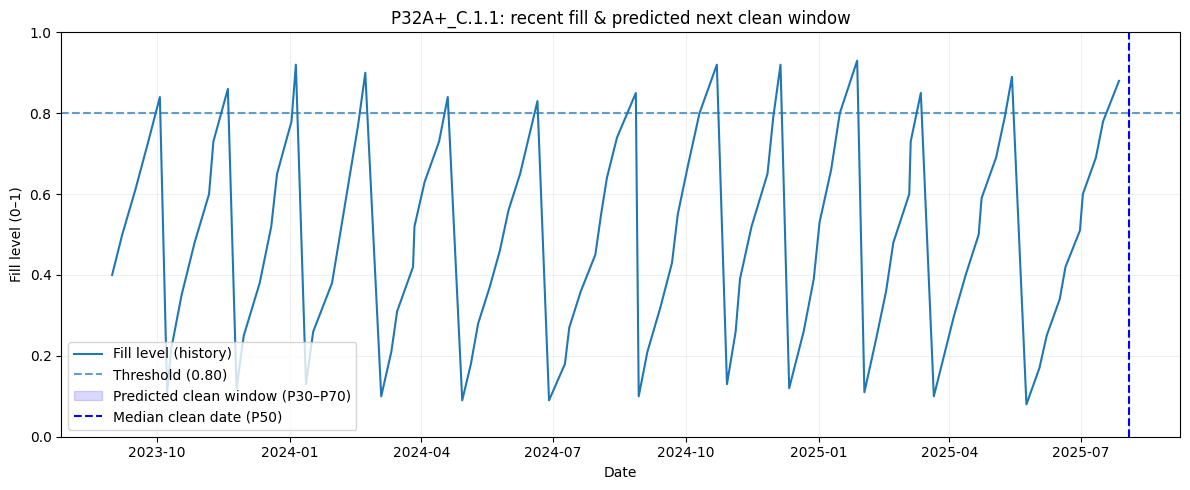

In [0]:
def plot_container_time_to_clean(container_id: str, lookback_weeks: int = 80, show=False):
    """
    Visualize recent fill levels + predicted time-to-clean (P30/P50/P70) for one container.
    Assumes the following DataFrames exist:
      - panel_feat: tidy panel with columns ['container','date','fill_level', ...]
      - out: test rows with columns ['container','date','fill_level',
            'weeks_until_clean_p30','weeks_until_clean_p50','weeks_until_clean_p70',
            'next_clean_date_p30','next_clean_date_p50','next_clean_date_p70']
      - schedule: last row per container with same *_p30/p50/p70 columns
    """

    # recent history
    hist = (panel_feat[panel_feat['container'] == container_id]
            .sort_values('date')
            .tail(lookback_weeks)
            .copy())

    if hist.empty:
        raise ValueError(f"No rows found for container '{container_id}'")

    # latest prediction row for this container (from schedule table)
    row = schedule[schedule['container'] == container_id]
    if row.empty:
        # fall back to the most recent 'out' row in test set
        row = (out[out['container'] == container_id]
               .sort_values('date')
               .tail(1))

    if row.empty:
        raise ValueError(f"No predictions available for '{container_id}'. Did you run the quantile models?")

    row = row.iloc[0]
    p30_date = pd.to_datetime(row['next_clean_date_p30'])
    p50_date = pd.to_datetime(row['next_clean_date_p50'])
    p70_date = pd.to_datetime(row['next_clean_date_p70'])

    # Build plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # Fill history
    ax.plot(hist['date'], hist['fill_level'], label='Fill level (history)')

    # Threshold line
    ax.axhline(THRESHOLD, linestyle='--', alpha=0.7, label='Threshold (0.80)')

    # prediction window as vertical shading (x-axis band)
    ax.axvspan(p30_date, p70_date, 
            ymin=0, ymax=1, 
            alpha=0.15, color="blue",
            label="Predicted clean window (P30–P70)")

    # median as a vertical line
    ax.axvline(p50_date, color="blue", linestyle="--", 
            label="Median clean date (P50)")


    # Formatting
    ax.set_title(f"{container_id}: recent fill & predicted next clean window")
    ax.set_xlabel("Date")
    ax.set_ylabel("Fill level (0–1)")
    ax.set_ylim(0, 1.0)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.close()
    plt.show()
    plt.close()
    return fig

# EXAMPLE: pick a container from your schedule table
example_container = schedule['container'].iloc[15]
plot_container_time_to_clean(example_container, lookback_weeks=100, show=True)

Log the metrics from gradient boosting regressor to ensure that all results are accessible and reproducible with MLFlow.

In [0]:
import mlflow, mlflow.sklearn
mlflow.set_experiment("/Shared/time_to_clean_quantiles")

with mlflow.start_run(run_name="GBR_quantiles_1.5"):
    mlflow.log_params({"models":"GBR quantiles", "n_estimators":N_ESTIMATORS, "lr":LEARNING_RATE, "max_depth":MAX_DEPTH})
    mlflow.log_metric("mae_weeks_p50", mae_q50)
    mlflow.sklearn.log_model(gbr_p30, "model_p30", input_example=X_te.head(1))
    mlflow.sklearn.log_model(gbr_p50, "model_p50", input_example=X_te.head(1))
    mlflow.sklearn.log_model(gbr_p70, "model_p70", input_example=X_te.head(1))
    # also log a sample of the schedule as an artifact CSV
    schedule.head(100).to_csv("/tmp/schedule_preview.csv", index=False)
    mlflow.log_artifact("/tmp/schedule_preview.csv", artifact_path="artifacts")

    # log all plots of container results

    [mlflow.log_figure(plot_container_time_to_clean(c, lookback_weeks=100), f"plots/time_to_clean_{c}.png") for c in list(schedule['container'].values)]




2025/09/10 07:21:00 INFO mlflow.tracking.fluent: Experiment with name '/Shared/time_to_clean_quantiles' does not exist. Creating a new experiment.


In [0]:
schedule

,container,fill_level,next_clean_date_p30,next_clean_date_p50,next_clean_date_p70,weeks_until_clean_p30,weeks_until_clean_p50,weeks_until_clean_p70
8406,P22_C.1.1,0.86,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,1.000456,1.000413,1.013799
2966,R64_C.1.1,0.86,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,2025-05-10 07:05:52.821779,1.000456,1.000413,1.013799
7005,P14_C.1.1,0.85,2025-05-31 07:05:52.821779,2025-05-31 07:05:52.821779,2025-05-31 07:05:52.821779,1.000456,1.000107,1.188277
6304,CT64_E.1.1,0.85,2025-06-09 07:05:52.821779,2025-06-09 07:05:52.821779,2025-06-09 07:05:52.821779,1.000456,1.000107,1.188277
14732,P32A+_E.1.2,0.83,2025-06-27 07:05:52.821779,2025-06-27 07:05:52.821779,2025-06-27 07:05:52.821779,0.997926,0.945471,1.267344
15435,P64_C.1.3,0.83,2025-07-07 07:05:52.821779,2025-07-07 07:05:52.821779,2025-07-07 07:05:52.821779,0.959128,0.983440,1.353927
4904,S22A+_E.1.2,0.83,2025-07-07 07:05:52.821779,2025-07-07 07:05:52.821779,2025-07-07 07:05:52.821779,0.959128,0.983440,1.353927
10521,S32_C.1.1,0.82,2025-07-09 07:05:52.821779,2025-07-09 07:05:52.821779,2025-07-09 07:05:52.821779,0.977548,1.001022,1.124284
343,CT22_C.1.1,0.83,2025-07-09 07:05:52.821779,2025-07-09 07:05:52.821779,2025-07-16 07:05:52.821779,1.023399,1.199576,1.683908
3326,R64_C.1.3,0.84,2025-07-09 07:05:52.821779,2025-07-09 07:05:52.821779,2025-07-16 07:05:52.821779,1.000456,1.155824,1.683908


Let us now see the outcome of using the 50th- quantile as our model against the true outcome and its predicted outcome. 

Train MAE=0.18, Test MAE=0.21
Train RMSE=0.37, Test RMSE=0.38


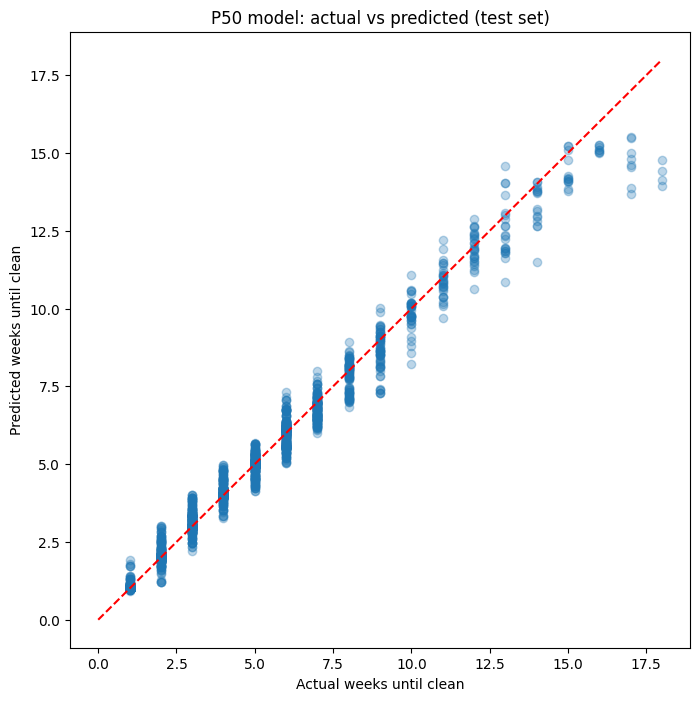

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

train_pred = gbr_p50.predict(X_tr)
test_pred  = gbr_p50.predict(X_te)

mae_train = mean_absolute_error(y_tr, train_pred)
mae_test  = mean_absolute_error(y_te, test_pred)
rmse_train = np.sqrt(mean_squared_error(y_tr, train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_te, test_pred))

print(f"Train MAE={mae_train:.2f}, Test MAE={mae_test:.2f}")
print(f"Train RMSE={rmse_train:.2f}, Test RMSE={rmse_test:.2f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(y_te, test_pred, alpha=0.3)
plt.plot([0, max(y_te)], [0, max(y_te)], 'r--')  # 1:1 line
plt.xlabel("Actual weeks until clean")
plt.ylabel("Predicted weeks until clean")
plt.title("P50 model: actual vs predicted (test set)")
plt.show()

Let us ensure that the gradient boosting regressor model is not overfitting with cross validation with evaluation of expected std being small. 

In [0]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)
scores = []
for train_idx, val_idx in tscv.split(X_tr):
    model = gbr_quantile(0.5)
    model.fit(X_tr.iloc[train_idx], y_tr.iloc[train_idx])
    pred = model.predict(X_tr.iloc[val_idx])
    mae = mean_absolute_error(y_tr.iloc[val_idx], pred)
    scores.append(mae)

print("CV MAE scores:", scores)
print("Mean:", np.mean(scores), "Std:", np.std(scores))


CV MAE scores: [0.19349276414693772, 0.4383420379932313, 0.22313671281637046, 0.2426054717511426, 0.25267747359442944, 0.1634095751904484, 0.15539209849710756, 0.12465612603081196, 0.17915120156724432, 0.2258302081115066]
Mean: 0.21986936696992299 Std: 0.08254338201141842


Above we see the result of splitting our data into folds using Cross-Validation. Notice how the MSE metric gets smaller the deeper the fold gets which is a good sign that our model is generalizing well near the tail end of training across time series folds. Early on our model MAE is larger most likely due to initialization issues in the creation of synthetic data. 

In [0]:
"""
## I/O Errors with Access denied for free trial of databricks

import pickle

model_path = "/dbfs/FileStore/gbr_p50_model.pkl" 
os.makedirs('/dbfs/FileStore/', exist_ok=True)
# Save the Regression model for n weeks out as a pickle file
with open(model_path, 'wb') as f:
  pickle.dump(gbr_p50, f)
  """

'\n## I/O Errors with Access denied for free trial of databricks\n\nimport pickle\n\nmodel_path = "/dbfs/FileStore/gbr_p50_model.pkl" \nos.makedirs(\'/dbfs/FileStore/\', exist_ok=True)\n# Save the Regression model for n weeks out as a pickle file\nwith open(model_path, \'wb\') as f:\n  pickle.dump(gbr_p50, f)\n  '